# Image Captioning

[Original video](https://youtu.be/y2BaTt1fxJU)

[Original implementation](https://github.com/aladdinpersson/Machine-Learning-Collection/tree/master/ML/Pytorch/more_advanced/image_captioning)

[Image captioning](https://github.com/yunjey/pytorch-tutorial/tree/master/tutorials/03-advanced/image_captioning) implementation by Yunjey Choi

[Flickr8k Dataset used](https://www.kaggle.com/dataset/e1cd22253a9b23b073794872bf565648ddbe4f17e7fa9e74766ad3707141adeb)

Previous implementations:
  * [How to build custom datasets for text in PyTorch](https://youtu.be/9sHcLvVXsns​) with the [source code](https://colab.research.google.com/drive/1JN2CuU9fvCZgEh1qVXtj3vDITleJSpqh)
  * [Recurrent Neural Network example](https://colab.research.google.com/drive/1oOQKP5Z7W_mimCndq91efQVMWuYd2VF3#scrollTo=32QWLsSRMSmQ) with [video](https://youtu.be/Gl2WXLIMvKA)
  * [Pytorch TensorBoard](https://colab.research.google.com/drive/1uftzYqL8gwmp2wvvujBHvRxfGLOxnO54) with [video](https://youtu.be/RLqsxWaQdHE)


## Load data. Create vocabulary

We want to convert text to numerical values.

1. We need a Vocabulary mapping each word to an index.
2. We need to setup PyTorch dataset to load the data.
3. Setup padding of every batch (all examples should be of the same seq_len and setup dataloader).

In [ ]:
# Get dataset from Kaggle

# Install kaggle packages if necessary. Not necessary for CoLab
# !pip install -q kaggle
# !pip install -q kaggle-cli

# Colab's file access feature
from google.colab import files

# Upload `kaggle.json` file
uploaded = files.upload()

# Retrieve uploaded file and print results
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))


# Then copy kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

# Download the dataset
#!kaggle datasets list -s flickr8k
!kaggle datasets download -d aladdinpersson/flickr8kimagescaptions

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 65 bytes
kaggle.json
100% 1.03G/1.04G [00:29<00:00, 67.4MB/s]
100% 1.04G/1.04G [00:29<00:00, 38.2MB/s]


In [ ]:
# Unzip dataset
import zipfile

with zipfile.ZipFile('flickr8kimagescaptions.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

In [ ]:
import os  # for file paths
import spacy  # for tokenizer
import requests
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd  # for lookup in annotation file
import torchvision.models as models
import torchvision.transforms as transforms
import multiprocessing  # get number of CPU workers for text processing
import matplotlib.pyplot as plt  # show images from the tensor

from PIL import Image  # load images
from torch.nn.utils.rnn import pad_sequence  # pad batch
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter

In [ ]:
class Vocabulary:
    def __init__(self, freq_threshold):
        # itos - index to string, UNK - unknown, PAD - padding
        self.itos = {0:'<PAD>', 1:'<SOS>', 2:'<EOS>', 3:'<UNK>'}
        # stoi - string to index
        self.stoi = {'<PAD>':0, '<SOS>':1, '<EOS>':2, '<UNK>':3}
        self.freq_threshold = freq_threshold
        # Download if necessary with:
        #   !python -m spacy download en
        self.spacy_eng = spacy.load('en')

    def __len__(self):
        return len(self.itos)

    def tokenizer_eng(self, text):
        # 'I love peanuts' ==> ['i', 'love', 'peanuts']
        return [tok.text.lower() for tok in self.spacy_eng.tokenizer(text)]

    def build_vocabulary(self, sentence_list):
        frequences = {}
        idx = 4

        for sentence in sentence_list:
            for word in self.tokenizer_eng(sentence):
                if word not in frequences:
                    frequences[word] = 1
                else:
                    frequences[word] += 1

                if frequences[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        # 'I love peanuts' ==> ['37', '123', '492']
        tokenized_text = self.tokenizer_eng(text)

        return [self.stoi[token] if token in self.stoi else self.stoi['<UNK>']
                for token in tokenized_text]


class FlickrDataset(Dataset):
    def __init__(self, root_dir, captions_file, transform=None, freq_threshold=5):
        self.root_dir = root_dir
        self.df = pd.read_csv(captions_file)
        self.transform = transform

        # Get image and caption columns
        self.imgs = self.df['image']
        self.captions = self.df['caption']

        # Initialize and build vocabulary
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocabulary(self.captions.tolist())

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        caption = self.captions[index]
        img_name = self.imgs[index]
        img = Image.open(os.path.join(self.root_dir, img_name)).convert('RGB')

        if self.transform is not None:
            img = self.transform(img)

        # stoi means 'string to index'
        # SOS means 'start of the sentence'
        # EOS means 'end of the sentence'
        numericalized_caption = [self.vocab.stoi['<SOS>']]
        numericalized_caption += self.vocab.numericalize(caption)
        numericalized_caption.append(self.vocab.stoi['<EOS>'])

        return img, torch.tensor(numericalized_caption)


class MyCollate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx  # padding index '<PAD>':0
    
    def __call__(self, batch):
        # convert (3, 224, 224) to (1, 3, 224, 224)
        imgs = [item[0].unsqueeze(0) for item in batch]
        # convert batch of (1, 3, 224, 224) images to (batch, 3, 224, 224) tensor
        imgs = torch.cat(imgs, dim=0)
        targets = [item[1] for item in batch]
        # batch_first=False => torch.Size([max-target, batch]) - batch is second in tensor
        targets = pad_sequence(targets, batch_first=False, padding_value=self.pad_idx)

        return imgs, targets


def get_loader(root_folder,
               annotation_file,
               transform,
               batch_size=32,
               num_workers=multiprocessing.cpu_count(),
               shuffle=True,
               pin_memory=True):

    dataset = FlickrDataset(root_folder, annotation_file, transform=transform)
    pad_idx = dataset.vocab.stoi['<PAD>']  # padding index '<PAD>':0
    loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=shuffle,
        pin_memory=pin_memory,
        collate_fn=MyCollate(pad_idx=pad_idx),
    )
    return loader, dataset

In [ ]:
# Resize each image and convert it to tensor
# If error: AttributeError: 'Compose' object has no attribute 'Compose
# then read this: https://stackoverflow.com/a/53497727/7550928
transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor(),])

dataloader, dataset = get_loader('flickr8k/images',
                                 annotation_file='flickr8k/captions.txt',
                                 transform=transform)

torch.Size([32, 3, 224, 224])
torch.Size([25, 32])


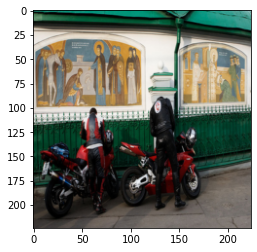

torch.Size([32, 3, 224, 224])
torch.Size([20, 32])


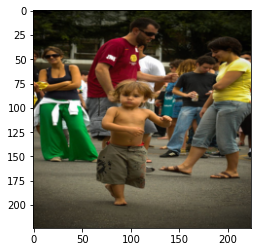

torch.Size([32, 3, 224, 224])
torch.Size([26, 32])


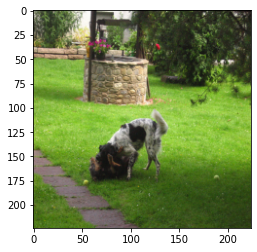

torch.Size([32, 3, 224, 224])
torch.Size([28, 32])


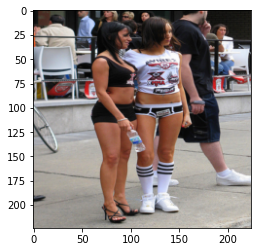

torch.Size([32, 3, 224, 224])
torch.Size([26, 32])


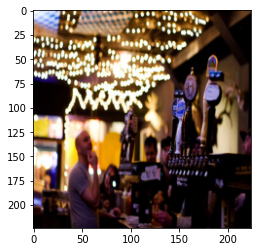

torch.Size([32, 3, 224, 224])
torch.Size([24, 32])


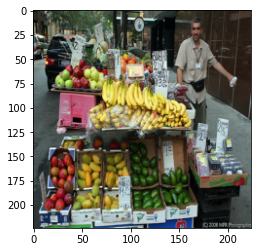

torch.Size([32, 3, 224, 224])
torch.Size([24, 32])


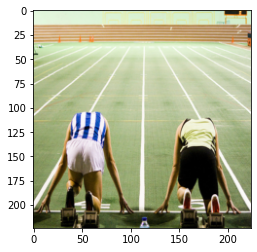

torch.Size([32, 3, 224, 224])
torch.Size([25, 32])


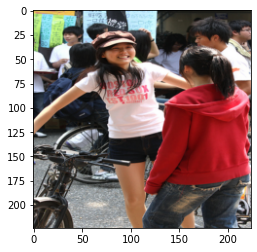

torch.Size([32, 3, 224, 224])
torch.Size([28, 32])


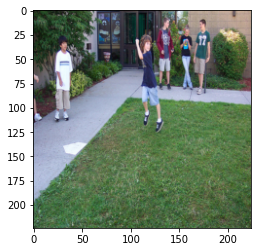

torch.Size([32, 3, 224, 224])
torch.Size([26, 32])


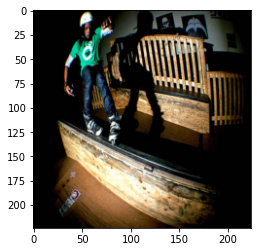

torch.Size([32, 3, 224, 224])
torch.Size([22, 32])


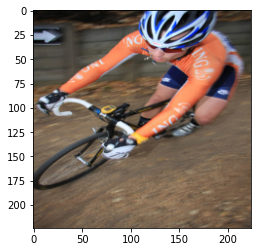

torch.Size([32, 3, 224, 224])
torch.Size([21, 32])


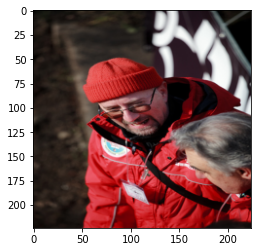

In [ ]:
# Check it
for idx, (imgs, captions) in enumerate(dataloader):
    print(imgs.shape)
    print(captions.shape)
    plt.imshow(imgs[0].permute(1, 2, 0))  # show 1st image in the batch
    plt.show()
    if idx > 10:
        break

## Create encoder CNN and decoder RNN. Hook them together

In [ ]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size, train_cnn=False):
        super(EncoderCNN, self).__init__()
        self.train_cnn = train_cnn  # don't train cnn to save time
        # import torchvision.models as models
        self.model = models.inception_v3(pretrained=True, aux_logits=False)
        # replace the last fully connected layer
        self.model.fc = nn.Linear(self.model.fc.in_features, embed_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, images):
        features = self.model(images)

        # freeze all parameters except the last one fully connected layer
        for name, param in self.model.named_parameters():
            if 'fc.weight' in name or 'fc.bias' in name:
                param.requires_grad = True
            else:
                param.requires_grad = self.train_cnn  # usually False
        
        return self.dropout(self.relu(features))


class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        # embed_size - input to LSTM
        # hidden_size - output from LSTM
        # vocab_size - each node represents 1 word in vocabulary
        # num_layers - how many layers of LSTM to stack on top of each other
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, features, captions):
        # features - output from EncoderCNN
        # captions - are the target captions in the dataset, some number of words
        embeddings = self.dropout(self.embed(captions))
        # concatenate features and embeddings, add dim=0 as a time step
        embeddings = torch.cat((features.unsqueeze(0), embeddings), dim=0)
        hiddens, _ = self.lstm(embeddings)
        outputs = self.linear(hiddens)
        return outputs


class CNNtoRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(CNNtoRNN, self).__init__()
        self.encoder = EncoderCNN(embed_size)
        self.decoder = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers)

    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs

    def caption_image(self, image, vocabulary, max_length=50):
        # max_length - number of words to predict
        result_caption = []

        with torch.no_grad():
            x = self.encoder(image).unsqueeze(0)  # add batch dimension
            states = None  # hidden and cell state for the LSTM

            for _ in range(max_length):  # predictions for 50 words here
                hiddens, states = self.decoder.lstm(x, states)
                output = self.decoder.linear(hiddens.squeeze(0))  # batch_size == 1
                predicted = output.argmax(1)

                result_caption.append(predicted.item())
                x = self.decoder.embed(predicted).unsqueeze(0)  # next input to LSTM

                # check the end of sentence
                if vocabulary.itos[predicted.item()] == '<EOS>':
                    break

        return [vocabulary.itos[idx] for idx in result_caption]

## Train the network

In [ ]:
# Show images
def print_image(model, device, dataset, filepath, msg_correct=None, show=False):
    transform = transforms.Compose(
        [
            transforms.Resize((299, 299)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )

    model.eval()

    test_img = transform(Image.open(filepath).convert('RGB')).unsqueeze(0)
    if msg_correct is not None:
        print(msg_correct)
    
    print('OUTPUT:  ' + ' '.join(model.caption_image(test_img.to(device), dataset.vocab)))

    model.train()

    if show:
        visualize(filepath)


def print_examples(model, device, dataset):
    if os.path.exists('Machine-Learning-Collection'):
        pass
    else:
        # Get Aladdin Persson GitHub repository
        !git clone https://github.com/aladdinpersson/Machine-Learning-Collection.git

    images_dir = 'Machine-Learning-Collection/ML/Pytorch/more_advanced/image_captioning/test_examples'

    print_image(model, device, dataset, os.path.join(images_dir, 'dog.jpg'),
                'CORRECT: Dog on a beach by the ocean')
    print_image(model, device, dataset, os.path.join(images_dir, 'child.jpg'),
                'CORRECT: Child holding red frisbee outdoors')
    print_image(model, device, dataset, os.path.join(images_dir, 'bus.png'),
                'CORRECT: Bus driving by parked cars')
    print_image(model, device, dataset, os.path.join(images_dir, 'boat.png'),
                'CORRECT: A small boat in the ocean')
    print_image(model, device, dataset, os.path.join(images_dir, 'horse.png'),
                'CORRECT: A cowboy riding a horse in the desert')


def visualize(img_list):
    if type(img_list) is str:
        img_list = [img_list]  # convert to list for single image
    for l in img_list:
        img = Image.open(l)
        # plt.figure(figsize=(10, 10))
        plt.imshow(img)
        plt.axis('off')
        plt.show()


def show(url):
    ' Show image by URL '

    _, dataset = get_loader(
        root_folder='flickr8k/images',
        annotation_file='flickr8k/captions.txt',
        transform=transform,
    )

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # initialize model, loss, etc.
    model = CNNtoRNN(256, 256, len(dataset.vocab), 1).to(device)
    optimizer = optim.Adam(model.parameters(), lr=3e-4)

    checkpoint = 'my_checkpoint.pth.tar'
    if os.path.exists(checkpoint):
        # step for TensorBoard
        step = load_checkpoint(torch.load(checkpoint), model, optimizer)
    else:
        print('No checkpoint')
        return

    if type(url) is str:
        url = [url]  # convert to list for single image

    for u in url:
        filename = u.split('/')[-1]  # get file name
        r = requests.get(u, allow_redirects=True)  # download image

        with open(filename, 'wb') as handler:  # save image
            handler.write(r.content)

        print_image(model, device, dataset, filename, msg_correct=None, show=True)


def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)


def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    step = checkpoint["step"]
    return step

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

# Start TensorBoard before training to monitor it in progress
%tensorboard --logdir runs

# Reload TensorBoard
%reload_ext tensorboard

# To fix the error, because PyTorch and TensorFlow are installed both:
# AttributeError: module 'tensorflow._api.v2.io.gfile' has no attribute 'get_filesystem'
import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

In [ ]:
# Train the model
def train():
    transform = transforms.Compose([
        transforms.Resize((299, 299)),  # before RandomCrop: (356, 356)
        # transforms.RandomCrop((299, 299)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

    train_loader, dataset = get_loader(
        root_folder='flickr8k/images',
        annotation_file='flickr8k/captions.txt',
        transform=transform,
    )

    torch.backends.cudnn.benchmark = True  # get some performance boost
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    filename = 'my_checkpoint.pth.tar'
    load_model = True
    save_model = True

    # Hyperparameters
    embed_size = 256
    hidden_size = 256
    vocab_size = len(dataset.vocab)
    num_layers = 1
    learning_rate = 3e-4
    num_epochs = 30  # 100

    # for TensorBoard
    writer = SummaryWriter('runs/flickr')
    step = 0

    # initialize model, loss, etc.
    model = CNNtoRNN(embed_size, hidden_size, vocab_size, num_layers).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi['<PAD>'])
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    if load_model and os.path.exists(filename):
        # step for TensorBoard
        step = load_checkpoint(torch.load(filename), model, optimizer)

    model.train()

    for epoch in range(num_epochs):
        
        if epoch % 5 == 0:
            print_examples(model, device, dataset)

        for idx, (imgs, captions) in enumerate(train_loader):
            imgs = imgs.to(device)
            captions = captions.to(device)
            
            # all captions except the last one, learn to predict the last end token
            outputs = model(imgs, captions[:-1])
            # (seq_length, batch_size, vocabulary_size) converto to (M, vocabulary_size)
            loss = criterion(outputs.reshape(-1, outputs.shape[2]), captions.reshape(-1))

            writer.add_scalar('Training loss', loss.item(), global_step=step)
            step += 1

            optimizer.zero_grad()
            loss.backward(loss)
            optimizer.step()

        if save_model:
            checkpoint = {
                'state_dict': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'step': step,
            }
            save_checkpoint(checkpoint)

In [ ]:
train()

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth



=> Loading checkpoint
Cloning into 'Machine-Learning-Collection'...
remote: Enumerating objects: 427, done.
remote: Counting objects: 100% (427/427), done.
remote: Compressing objects: 100% (334/334), done.
remote: Total 688 (delta 179), reused 242 (delta 80), pack-reused 261
Receiving objects: 100% (688/688), 20.73 MiB | 21.77 MiB/s, done.
Resolving deltas: 100% (230/230), done.
CORRECT: Dog on a beach by the ocean
OUTPUT:  <SOS> a dog is running through the water . <EOS>
CORRECT: Child holding red frisbee outdoors
OUTPUT:  <SOS> a little girl in a pink shirt is playing with a hula hoop . <EOS>
CORRECT: Bus driving by parked cars
OUTPUT:  <SOS> a man in a red shirt is standing in front of a crowd of people . <EOS>
CORRECT: A small boat in the ocean
OUTPUT:  <SOS> a man in a wetsuit is surfing . <EOS>
CORRECT: A cowboy riding a horse in the desert
OUTPUT:  <SOS> a man and a dog are standing in a field of dry grass . <EOS>
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


=> Loading checkpoint
OUTPUT:  <SOS> a man and woman pose for a picture . <EOS>


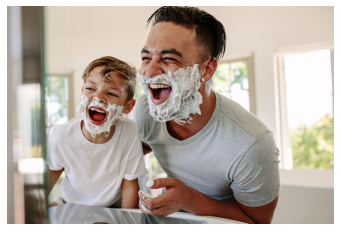

OUTPUT:  <SOS> a man in a red shirt is holding a camera . <EOS>


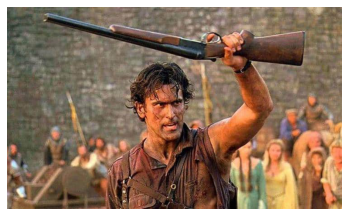

OUTPUT:  <SOS> a boy in a red shirt is jumping in the air . <EOS>


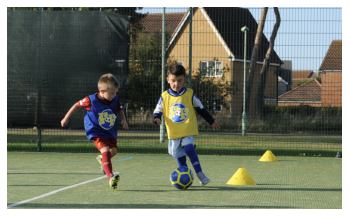

In [ ]:
show([
    'https://education.okstate.edu/outreach/fcs/Co-parenting-The-unique-role-of-fathers.jpg',
    'https://spikeybits.com/wp-content/uploads/2017/07/boom.jpg',
    'https://static.wixstatic.com/media/3933dc_a7c200c43f964b5dba52ea6046d7c6ed~mv2.jpg',
])